# Forecast verification
This is the main notebook of the study containing all the central analysis.

## Data processing
The most daunting task is aligning the original dataset with the data format expected by climpred. Also see **Terminology** at bottom of notebook.

* Check CERRA dataset? Not sure, first also have a look at HYRAS or GCPC?
    * try with ERA5 data for now and get skill metrics working in climpred first
    * only thereafter experiment with the HYRAS data and see if I can get it on the same grid (projection!)
        * If I continue with the HYRAS dataset, check script from Jens


### Bias correction
* check multiplicative bias https://climpred.readthedocs.io/en/stable/metrics.html#multiplicative-bias
* [It’s safest to do anything like climatology removal before constructing climpred objects](https://climpred.readthedocs.io/en/stable/prediction-ensemble-object.html) -> In short, any sort of bias correcting or drift correction can also be done **prior** to instantiating a PredictionEnsemble object.
* do bias correction before actual skill computation
* Check the SYDRO notebook on bias correction
* https://climpred.readthedocs.io/en/stable/api/climpred.classes.HindcastEnsemble.remove_bias.html#climpred.classes.HindcastEnsemble.remove_bias
    * how to apply a simple bias correction to the precipitation dataset?
    * it wraps from XCLIM!
    * https://climpred.readthedocs.io/en/stable/bias_removal.html

### Forecast verification
* see "Effective Sample Size" -> should I use it? see https://doi.org/10.1175/1520-0442(1999)012<1990:TENOSD>2.0.CO;2  Also compute the p values! Understand how this is used in forecast verification!

* Check more verification datasets in one HindcastEnsemble? [Note](https://youtu.be/EcMxImmMBec?t=8526) more than one verification dataset can be carried along! This allows to compare the skill for multiple observational datasets.

# Misc TODO

## Climpred things
* Make sure that your init and lead dimensions align.* --> maybe I need to have the same number of init dates as lead timesteps. Try the xarray align method??? See https://climpred.readthedocs.io/en/stable/quick-start.html
* Check: [Note](https://youtu.be/EcMxImmMBec?t=8647) a skill dimension is appended to the HindcastEnsemble object which allows to compare the skills of the forecast product and the skill of the reference forecast (e.g. persistence) -> good plot of the spatial distribution of skill in two rows, one for the forecast product and the other one for the reference product
* --> just not sure how e.g. the ACC is computed then if we are not even in anomaly space. Does climpred actually compute anomalies?

## EOF analysis
* compute the EOFs
    * https://ajdawson.github.io/eofs/latest/
    * read Wilks chapter

## Detrending
* https://climpred.readthedocs.io/en/stable/api/climpred.stats.rm_poly.html#climpred.stats.rm_poly
    * or better in XCLIM or straight away in Xarray?
    * see here: https://youtu.be/SKXUBD6DGao?t=563
* I will probably not need to worry about detrending at seasonal timescales... where is literature which specifies at which time intervals detrending becomes relevant? Do I need to justify?

## Parallelisation, dask and numba
* NUMBA
    * read a bit into Numba, safe for later in job to see if it makes sense,
    recommended [here](https://docs.dask.org/en/latest/array-best-practices.html)
    * speedups vs. scalability

## Git
* read and understand Git Pro
* fork climpred
* understand the package
* possibly add to the source code

In [5]:
# %%time
# # set up a local dask cluster for parallelisation and accessing the dashboard
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()  # Launches a scheduler and workers locally
# client = Client(cluster)  # Connect to distributed cluster and override default
# # client = Client(address="127.0.0.1:8787")
# client

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm
import shutil


import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from Dataprocessing import get_daily_tp_rate, prep_hindcast, crop_netCDF

# from verification import get_inits, load_hindcast_data, load_verification_data
from climpred.preprocessing.shared import set_integer_time_axis
from climpred import HindcastEnsemble
# from climpred.utils import convert_init_lead_to_valid_time_lead

C:\Users\sb123\.conda\envs\Thesis2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading and pre-processing observations
Read in "quasi-observations" from ERA5, which have been (conservatively) regridded from 0.25°x0.25° latlon to 1°x1° latlon (using MPI CDO), cropped to the spatial domain of interest (5 - 15W and 47 to 55N) and also aggregated (sum) from hourly to daily values by using function Dataprocessing.ERA5_hourly_daily().

Data amount of ERA5 seems to be OK to handle: 831699 datapoints. Shape: (8401, 9, 11)

The ERA5 data still contains some very small negative values, which are replaced with zeros in the next step:
-8.940698171500117e-05 

Now the data looks good
Max. daily precipitation: 94.08016967773438
Min. daily precipitation: 0.0 

CPU times: total: 344 ms
Wall time: 1.12 s


[Text(0.5, 1.0, 'ERA5 pr histogram')]

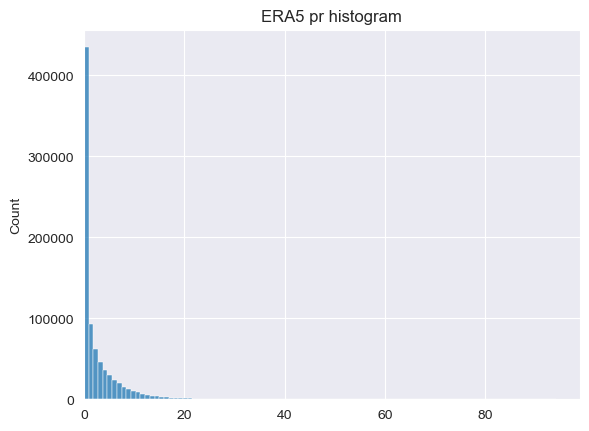

In [2]:
%%time
obs = xr.open_dataset(r"C:\Users\sb123\Documents\Massendaten\Observations.nc")["tp"]
print(f"Data amount of ERA5 seems to be OK to handle: {obs.size} datapoints. Shape: {obs.shape}\n")
attrs = obs.attrs
obs = obs * 1000 #Careful: Attrs are dropped when doing basic arithmetics: https://github.com/pydata/xarray/issues/1271
obs.attrs = {"units":"mm"} #add back attributes

print("The ERA5 data still contains some very small negative values, which are replaced with zeros in the next step:")
print(f"{obs.values.min()} \n")

# I did not find a straightforward way of replacing all negative pr values with zeros in Xarray. Workaround:
obs = obs.where(obs > 0) # negative values to NAN
obs = obs.fillna(0) # NaNs to 0
print("Now the data looks good")
print(f"Max. daily precipitation: {obs.max().values}")
print(f"Min. daily precipitation: {obs.min().values} \n")

fig, ax = plt.subplots()
sns.histplot(obs.values.flat, ax=ax, bins=100)
ax.set_xlim(left=0)
ax.set(title="ERA5 pr histogram")

# Reading and pre-processing SEAS5 model data
## Disaggregation
At first a box of lat 47 - 55N and lon 5 - 15E will be cropped.

Then the accumulated total precipitation data will need to be disaggregated over dim = "time": https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790



In [ ]:
%%time
crop_netCDF(r"D:\Massendaten\ECMWF\SEAS5_Global", 47, 55, 5, 15, globpat="*_total_precipitation.nc", to_netcdf=True)

In [ ]:
%%time
get_daily_tp_rate(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped", r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated", globpat="*total_precipitation_box.nc")

Before analysing the data I run some plausibility checks / compute basic statistics to see if there are any problems with the data. This includes plotting a histogram over all daily tp values for each file and storing the files in a folder on disk for inspection.

In [ ]:
path = Path(r"D:\Massendaten\ECMWF\SEAS5_Global")
for file in tqdm(list((path).glob("*_total_precipitation.nc"))):
    da = xr.open_dataset(file, chunks="auto)["tp"]
    da *= 1_000
    fig, ax = plt.subplots()
    sns.histplot(da.stack(all = ["time", "number", "latitude", "longitude"]).values, bins = 50, ax=ax)
    fig.savefig(path / (file.parts[-1][:-3] + ".png"), dpi=300)
    plt.close()

The issue with the interspersed histograms with giant outlier values and the rest of the distribution centered on zero persists. This is why for now I filter out all datasets with max() values larger than 300 mm.

## Pre-processing
Now the data needs to be modified so that it complies to the climpred requirements: https://climpred.readthedocs.io/en/stable/setting-up-data.html

This includes mostly manipulations to the coords and dims, e.g. converting the time axis to int days lead or adding an init dimension along which the datasets are concatenated, which specifies the initialisation date of each forecast (i.e. the 1st day of each month for SEAS5).

For details, see Dataprocessing.prep_hindcast()

In [2]:
# Read in hindcast data as climpred.HindcastEnsemble
datasets = []
count = 0

print("Some strange outliers (daily tp in mm):")
files = list(Path(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated").glob("*disaggregated.nc"))
for file in files:
    ds = xr.open_dataset(file, chunks="auto")

    if (ds["tp"].max() * 1_000).values > 300:
        print((ds["tp"] * 1_000).max().values)
        count += 1
        continue
    else:
        ds = ds.rename({"number": "member"})
        ds = ds.assign_coords({"init": (ds.time.values[0] - np.timedelta64(1, "D"))}).expand_dims("init")
        ds = set_integer_time_axis(ds)
        ds = ds.rename({"time": "lead"})
        ds.lead.attrs["units"] = "days"
        datasets.append(ds)
print(f"A total of {count} of {len(files)} datasets was rejected.")

hc = xr.concat(datasets, dim="init")

hc = hc["tp"]
print(f"{hc.size} data points... quite a bit of data! Shape: {hc.shape}")
attrs = hc.attrs
hc *= 1_000 # conversion to mm
hc.attrs = {"units":"mm"} # add back attrs

# Sanitizing of <0 values as above:
print("Just like the observations the forecasts also contain negative pr values:")
print(f"Min. {hc.min().values} \n")
hc = hc.where(hc > 0) # negative values to NAN
hc = hc.fillna(0)

print("Now the data looks good")
print(f"Max. daily precipitation: {hc.max().values}")
print(f"Min. daily precipitation: {hc.min().values} \n")

# fig, ax = plt.subplots()
# sns.histplot(hc.values.flat, ax=ax, bins=100)
# ax.set_xlim(left=0)
# ax.set(title="SEAS5 tp histogram")

hindcast = HindcastEnsemble(hc)
hindcast = hindcast.add_observations(obs)

Some strange outliers (daily tp in mm):
5670.3594
6535.2783
6623.678
5666.382
6229.126
6399.17
5302.9785
3352.7646
5862.3457
5353.4746
5412.4756
6513.3564
5784.5796
5043.348
5590.088
6354.208
5675.171
4959.3506
5357.666
5292.9688
A total of 20 of 276 datasets was rejected.
136224000 data points... quite a bit of data! Shape: (256, 25, 9, 11, 215)
Just like the observations the forecasts also contain negative pr values:
Min. -0.2396106719970703 

Now the data looks good
Max. daily precipitation: 135.79415893554688
Min. daily precipitation: 0.0 



C:\Users\sb123\.conda\envs\Thesis2\lib\site-packages\climpred\classes.py:987: UserWarning: HindcastEnsemble is chunked along dimensions ['init'] with more than one chunk. `HindcastEnsemble.chunks=Frozen({'init': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'member': (25,), '

NameError: name 'obs' is not defined

20 Files will be discarded (for now). This is identical to the number of figures, where the histogram looks odd (see cells above)

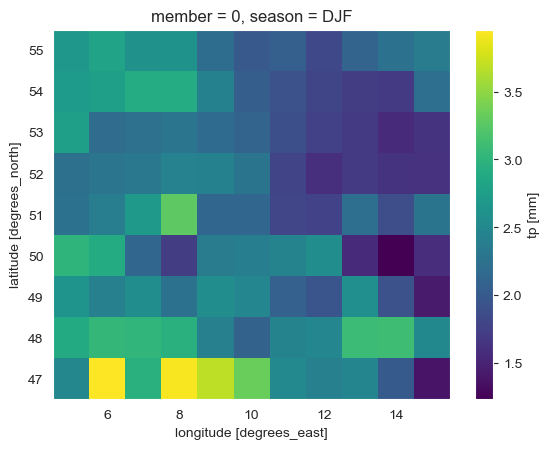

In [14]:
hc_seasons = hindcast.get_initialized().groupby("valid_time.season").mean()#.mean("member")["tp"]
hc_seasons.isel({"season":0,"member":0})["tp"].plot() #.isel({"member":0, "lead":0, "init":0})["tp"].plot()

In [14]:
# Let's check the seasons for the observation so that we can compare with the SEAS5 climatology.
obs_seasons = obs.resample(time="1QS").sum().groupby("time.season").mean()
hc_seasons = hindcast.get_initialized().groupby("valid_time.season").mean().mean("member")["tp"]

C:\Users\sb123\AppData\Local\Temp\ipykernel_20996\522219042.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


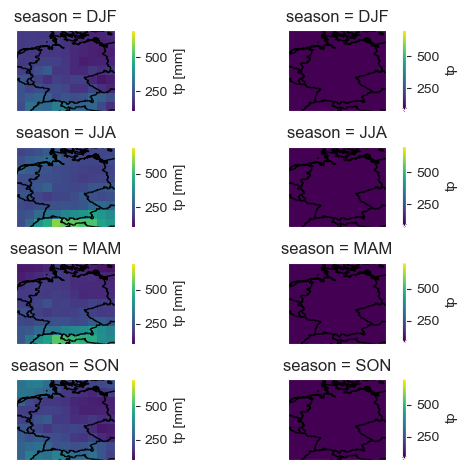

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=2, subplot_kw={"projection" : ccrs.PlateCarree()})
for i in range(0,4):
    obs_seasons[i].plot(ax=ax[i,0], vmin=100, vmax=700)
    hc_seasons[i].plot(ax=ax[i,1], vmin=100, vmax=700)

for axes in ax.flat:
    axes.add_feature(cfeature.BORDERS)
    axes.add_feature(cfeature.COASTLINE)
plt.tight_layout()
fig.show()

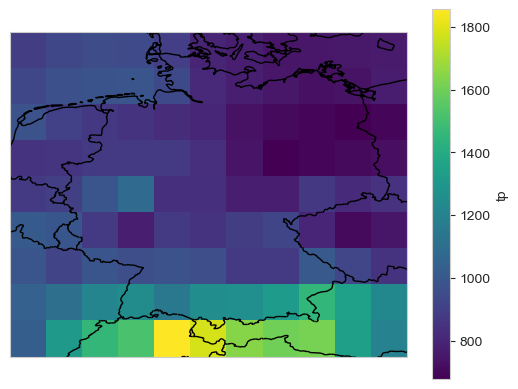

In [20]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
obs.resample(time="1Y").sum().mean("time").plot(ax=ax)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

In [18]:
# instantiate a climpred HindcastEnsemble object


# Testing only:
# hc = hc.assign_coords({"month" : hc.init.dt.month.values}) # for testing to
# filter for inits on a specific month to compare results against https://meteoswiss-climate.shinyapps.io/skill_metrics/


C:\Users\sb123\.conda\envs\Thesis2\lib\site-packages\climpred\classes.py:987: UserWarning: HindcastEnsemble is chunked along dimensions ['init'] with more than one chunk. `HindcastEnsemble.chunks=Frozen({'init': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'member': (25,), '

TypeError: 'function' object is not iterable

In [ ]:
convert_init_lead_to_valid_time_lead(hindcast.get_initialized())

In [ ]:
# Doing some visualisations and plausibility checks on our climpred
# HindcastEnsemble

# fig, ax = plt.subplots()
data = hindcast.get_observations().tp.values.flat
# import numpy as np
data[np.where(data < 0)[0]]

# sns.histplot(data=hindcast.get_observations().tp.values[:,0,0])

In [ ]:
# compute multiplicative bias (i.e. forecast/observations for each lead and
# init) #TODO decide which alignment to use -> literature?
mult_bias = hindcast.verify(metric="multiplicative_bias",comparison="e2o", alignment="same_inits", dim="init")
print(mult_bias)

In [ ]:
# Analyse the  multiplicative bias
# 1. Check dependence of bias on lead time for the whole area. Is there a
# systematic correlation?


In [ ]:
%time
#
verification_e2o = hindcast.verify(
    metric="pearson_r", comparison="e2o", dim="init", alignment="same_inits"
)

In [ ]:
verification_e2o

**Check, do I still have a member dimension when verifying with m2o?**

**ToDo:** Also calculate the p - values and research the underlying
methodology (see Wilks 2019)

Da läuft noch was schief mit den Verification Alignments

In [ ]:
fig, ax = plt.subplots(
    ncols=2, figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)
verification.sel({"lead": 1})["tp"].plot(ax=ax[0], vmin=0, vmax=0.6)
verification.sel({"lead": 100})["tp"].plot(ax=ax[1], vmin=0, vmax=0.6)

for ax in ax.flatten():
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
plt.tight_layout()

In [ ]:
verification.dims

In [ ]:
fig, ax = plt.subplots()
y = verification.tp.sel({"longitude": 5, "latitude": 55}).values
x = verification.lead.values
ax.plot(x, y)
fig.show()

# TODO compute manually and compare the graphs!

In [ ]:
verification.tp.shape

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
verification.tp.sel({"lead": 30}).plot(ax=ax)
ax.add_feature(cfeature.COASTLINE)
fig.show()

In [ ]:
verification.tp.sel({"lead": 30})

# Terminology
As retrieved from [here](https://climpred.readthedocs.io/en/stable/)
* **initialized ensemble** the hindcast or forecast DataSet which includes the members
* **member** a member of an ensemble (forecast)
* See more terminology guidance [here](https://climpred.readthedocs.io/en/stable/terminology.html)